## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [28]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [29]:
train, test = keras.datasets.cifar10.load_data()

In [30]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [31]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [32]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [33]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [34]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75, 0.9]
redice_lr_patient = [5, 10, 15]

In [35]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

Epoch 14/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2460 - acc: 0.5692 - val_loss: 1.4745 - val_acc: 0.4795
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2258 - acc: 0.5772 - val_loss: 1.4684 - val_acc: 0.4833
Epoch 16/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2061 - acc: 0.5836 - val_loss: 1.4648 - val_acc: 0.4783
Epoch 17/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.1859 - acc: 0.5911 - val_loss: 1.4565 - val_acc: 0.4871
Epoch 18/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1677 - acc: 0.5976 - val_loss: 1.4580 - val_acc: 0.4852
Epoch 19/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1489 - acc: 0.6037 - val_loss: 1.4622 - val_acc: 0.4894
Epoch 20/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.1291 - acc: 0.6126 - val_loss: 1.4511 - val_acc: 0.4919
Epoch 21/25
50000/50000 [=========

50000/50000 [==============================] - 4s 72us/step - loss: 2.2254 - acc: 0.2703 - val_loss: 2.1788 - val_acc: 0.2995
Epoch 2/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.7660 - acc: 0.3853 - val_loss: 1.8657 - val_acc: 0.3662
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6386 - acc: 0.4265 - val_loss: 1.6984 - val_acc: 0.4095
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5658 - acc: 0.4492 - val_loss: 1.6388 - val_acc: 0.4310
Epoch 5/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5106 - acc: 0.4686 - val_loss: 1.6157 - val_acc: 0.4331
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4665 - acc: 0.4870 - val_loss: 1.5754 - val_acc: 0.4410
Epoch 7/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4280 - acc: 0.5009 - val_loss: 1.5610 - val_acc: 0.4533
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 3s 54us/step - loss: 1.0651 - acc: 0.6372 - val_loss: 1.4487 - val_acc: 0.4958
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.0474 - acc: 0.6439 - val_loss: 1.4506 - val_acc: 0.4933
Numbers of exp: 5, reduce_factor: 0.75, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2924 - acc: 0.5478 - val_loss: 1.4982 - val_acc: 0.4800
Epoch 13/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2710 - acc: 0.5568 - val_loss: 1.4864 - val_acc: 0.4825
Epoch 14/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.2490 - acc: 0.5651 - val_loss: 1.4969 - val_acc: 0.4779
Epoch 15/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2279 - acc: 0.5737 - val_loss: 1.4803 - val_acc: 0.4820
Epoch 16/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2104 - acc: 0.5798 - val_loss: 1.4774 - val_acc: 0.4847
Epoch 17/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1891 - acc: 0.5879 - val_loss: 1.4703 - val_acc: 0.4895
Epoch 18/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1697 - acc: 0.5959 - val_loss: 1.4625 - val_acc: 0.4931
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 79us/step - loss: 2.2377 - acc: 0.2655 - val_loss: 2.1332 - val_acc: 0.3095
Epoch 2/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.7732 - acc: 0.3816 - val_loss: 1.8357 - val_acc: 0.3696
Epoch 3/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6418 - acc: 0.4242 - val_loss: 1.7158 - val_acc: 0.3998
Epoch 4/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.5683 - acc: 0.4492 - val_loss: 1.6702 - val_acc: 0.4156
Epoch 5/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5130 - acc: 0.4685 - val_loss: 1.6115 - val_acc: 0.4275
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4698 - acc: 0.4852 - val_loss: 1.5890 - val_acc: 0.4425
Epoch 7/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4313 - acc: 0.4982 - val_loss: 1.5636 - val_acc

50000/50000 [==============================] - 3s 56us/step - loss: 0.4705 - acc: 0.8621 - val_loss: 1.5286 - val_acc: 0.5262
Epoch 23/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.4535 - acc: 0.8693 - val_loss: 1.5333 - val_acc: 0.5246
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.4433 - acc: 0.8720 - val_loss: 1.5348 - val_acc: 0.5271
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.4310 - acc: 0.8800 - val_loss: 1.5536 - val_acc: 0.5291
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batc

50000/50000 [==============================] - 3s 54us/step - loss: 1.1790 - acc: 0.5940 - val_loss: 1.4592 - val_acc: 0.4872
Epoch 10/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.1527 - acc: 0.6021 - val_loss: 1.4365 - val_acc: 0.4905
Epoch 11/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1274 - acc: 0.6122 - val_loss: 1.4404 - val_acc: 0.4945
Epoch 12/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1022 - acc: 0.6218 - val_loss: 1.4335 - val_acc: 0.5020
Epoch 13/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.0792 - acc: 0.6321 - val_loss: 1.4387 - val_acc: 0.4988
Epoch 14/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.0568 - acc: 0.6397 - val_loss: 1.4101 - val_acc: 0.5078
Epoch 15/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.0372 - acc: 0.6473 - val_loss: 1.4314 - val_acc: 0.4968
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.9308 - acc: 0.3405 - val_loss: 2.0396 - val_acc: 0.3361
Epoch 2/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.5773 - acc: 0.4487 - val_loss: 1.6395 - val_acc: 0.4229
Epoch 3/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.4816 - acc: 0.4797 - val_loss: 1.5928 - val_acc: 0.4438
Epoch 4/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4167 - acc: 0.5030 - val_loss: 1.5690 - val_acc: 0.4483
Epoch 5/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3690 - acc: 0.5226 - val_loss: 1.5249 - val_acc: 0.4562
Epoch 6/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3273 - acc: 0.5381 - val_loss: 1.5093 - val_acc: 0.4661
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2927 - acc: 0.5511 - val_loss: 1.4863 - val_ac

50000/50000 [==============================] - 3s 55us/step - loss: 0.9627 - acc: 0.6778 - val_loss: 1.4656 - val_acc: 0.4900
Epoch 25/25
50000/50000 [==============================] - 3s 55us/step - loss: 0.9487 - acc: 0.6821 - val_loss: 1.4389 - val_acc: 0.5002
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_64 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1720 - acc: 0.5971 - val_loss: 1.4476 - val_acc: 0.4857
Epoch 13/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.1529 - acc: 0.6040 - val_loss: 1.4464 - val_acc: 0.4920
Epoch 14/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1326 - acc: 0.6118 - val_loss: 1.4493 - val_acc: 0.4919
Epoch 15/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.1145 - acc: 0.6199 - val_loss: 1.4464 - val_acc: 0.4899
Epoch 16/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0967 - acc: 0.6271 - val_loss: 1.4344 - val_acc: 0.4942
Epoch 17/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0800 - acc: 0.6322 - val_loss: 1.4261 - val_acc: 0.5018
Epoch 18/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0639 - acc: 0.6390 - val_loss: 1.4223 - val_acc: 0.4979
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.8585 - acc: 0.3646 - val_loss: 2.8894 - val_acc: 0.2475
Epoch 2/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5386 - acc: 0.4564 - val_loss: 2.9597 - val_acc: 0.2257
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.4195 - acc: 0.4970 - val_loss: 2.1294 - val_acc: 0.3092
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3421 - acc: 0.5230 - val_loss: 1.9980 - val_acc: 0.3533
Epoch 5/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2727 - acc: 0.5495 - val_loss: 1.6409 - val_acc: 0.4346
Epoch 6/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2164 - acc: 0.5699 - val_loss: 2.0424 - val_acc: 0.3502
Epoch 7/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.1592 - acc: 0.5890 - val_loss: 1.7836 - val_ac

50000/50000 [==============================] - 3s 53us/step - loss: 0.8807 - acc: 0.7062 - val_loss: 1.6289 - val_acc: 0.4586
Epoch 23/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.8603 - acc: 0.7132 - val_loss: 1.5587 - val_acc: 0.4756
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.8418 - acc: 0.7213 - val_loss: 1.5197 - val_acc: 0.4878
Epoch 25/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.8199 - acc: 0.7273 - val_loss: 1.5853 - val_acc: 0.4782
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batc

Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1786 - acc: 0.5935 - val_loss: 1.8579 - val_acc: 0.4104
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1505 - acc: 0.6036 - val_loss: 1.6715 - val_acc: 0.4316
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1188 - acc: 0.6148 - val_loss: 1.5131 - val_acc: 0.4714
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0904 - acc: 0.6265 - val_loss: 1.6968 - val_acc: 0.4223
Epoch 14/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0659 - acc: 0.6352 - val_loss: 1.5183 - val_acc: 0.4694
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0383 - acc: 0.6449 - val_loss: 1.5107 - val_acc: 0.4694
Epoch 16/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0137 - acc: 0.6551 - val_loss: 1.4689 - val_acc: 0.4904
Epoch 17/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.9985 - acc: 0.3201 - val_loss: 2.1580 - val_acc: 0.3027
Epoch 2/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6841 - acc: 0.4103 - val_loss: 1.8143 - val_acc: 0.3795
Epoch 3/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5653 - acc: 0.4527 - val_loss: 1.7698 - val_acc: 0.3896
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4861 - acc: 0.4807 - val_loss: 1.7535 - val_acc: 0.4002
Epoch 5/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4265 - acc: 0.5000 - val_loss: 1.7780 - val_acc: 0.3986
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3760 - acc: 0.5199 - val_loss: 1.5740 - val_acc: 0.4511
Epoch 7/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3316 - acc: 0.5348 - val_loss: 1.6095 - val_ac

50000/50000 [==============================] - 3s 52us/step - loss: 0.9259 - acc: 0.6898 - val_loss: 1.4945 - val_acc: 0.4886
Epoch 24/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.9077 - acc: 0.6967 - val_loss: 1.4618 - val_acc: 0.4945
Epoch 25/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.8901 - acc: 0.7044 - val_loss: 1.6105 - val_acc: 0.4664
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_94 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_lay

50000/50000 [==============================] - 3s 55us/step - loss: 1.2609 - acc: 0.5624 - val_loss: 1.5308 - val_acc: 0.4669
Epoch 11/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2320 - acc: 0.5733 - val_loss: 1.5496 - val_acc: 0.4692
Epoch 12/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2051 - acc: 0.5840 - val_loss: 1.5043 - val_acc: 0.4734
Epoch 13/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1777 - acc: 0.5946 - val_loss: 1.5844 - val_acc: 0.4474
Epoch 14/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1526 - acc: 0.6035 - val_loss: 1.5328 - val_acc: 0.4703
Epoch 15/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1290 - acc: 0.6130 - val_loss: 1.5005 - val_acc: 0.4752
Epoch 16/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1066 - acc: 0.6210 - val_loss: 1.4802 - val_acc: 0.4823
Epoch 17/25
50000/50000 [=====================

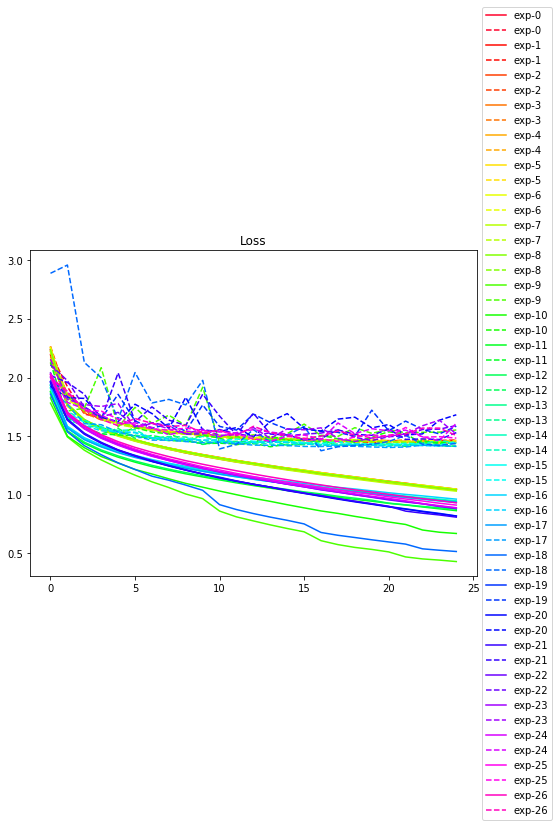

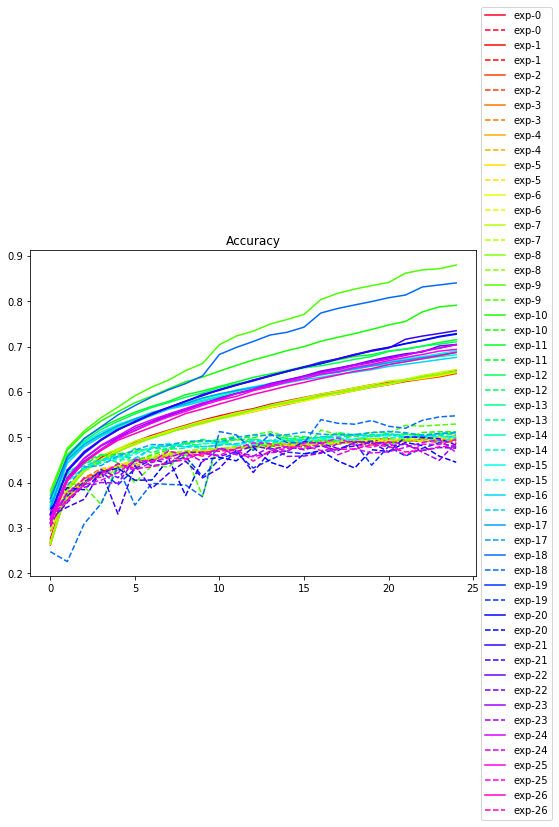

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()